## Model selection and trainign


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import pickle
import time

In [13]:

# Load the processed data
df = pd.read_csv('processed_traffic_data.csv')

# Separate features and target
X = df.drop('Accident', axis=1)
y = df['Accident']

In [ ]:
# Add before model training
print("Adding domain-specific risk interaction features...")

# Create meaningful interaction features
X['Alcohol_Night'] = df['Driver_Alcohol_scaled'] * (df['Time_of_Day_encoded'] >= 3).astype(int)
X['Speed_Wet_Road'] = df['Speed_Limit_scaled'] * ((df['Road_Condition_Wet'] > 0) | 
                                                (df['Road_Condition_Icy'] > 0)).astype(int)
X['Motorcycle_Speed'] = df['Speed_Limit_scaled'] * (df['Vehicle_Type_Motorcycle'] > 0).astype(int)
X['Low_Visibility_Speed'] = df['Speed_Limit_scaled'] * (df['Road_Light_Condition_No Light'] > 0).astype(int)

# Create age groups instead of continuous variable
df['Age_Group'] = pd.cut(df['Driver_Age_scaled'], 
                        bins=[-1, 0.25, 0.5, 0.75, 1], 
                        labels=['Young', 'Adult', 'Middle', 'Senior'])
age_dummies = pd.get_dummies(df['Age_Group'], prefix='Age', drop_first=True)
X = pd.concat([X, age_dummies], axis=1)

# Retrain test/train split with new features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")


Adding domain-specific risk interaction features...
Training set shape: (638, 29), Testing set shape: (160, 29)


: 

: 

: 

In [20]:
# Define evaluation function for classification
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    # Start timer
    start_time = time.time()
    
    # Train model
    model.fit(X_train, y_train)
    
    # Training time
    train_time = time.time() - start_time
    
    # Get predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probability predictions for ROC-AUC (if available)
    try:
        y_test_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_test_proba)
    except:
        roc_auc = None
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
     # Print results
    print(f"\n{model_name}:")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Testing Accuracy: {test_acc:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}" if roc_auc is not None else "ROC-AUC Score: Not available")
    print(f"Training Time: {train_time:.2f} seconds")
    
    # Generate confusion matrix
    # cm = confusion_matrix(y_test, y_test_pred)
    # plt.figure(figsize=(6, 4))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
    #             xticklabels=['No Accident', 'Accident'],
    #             yticklabels=['No Accident', 'Accident'])
    # plt.title(f'Confusion Matrix - {model_name}')
    # plt.ylabel('True Label')
    # plt.xlabel('Predicted Label')
    # plt.tight_layout()
    # plt.show()
    
        # Classification report
    # print("\nClassification Report:")
    # print(classification_report(y_test, y_test_pred))
    
    # Return key metrics for comparison
    return {
        "model_name": model_name, 
        "model": model,
        "test_accuracy": test_acc, 
        "f1_score": test_f1,
        "roc_auc": roc_auc if roc_auc is not None else 0,
        "training_time": train_time
    }

In [21]:

# Define models for classification
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(
        n_estimators=200, 
        max_depth=8,                  # Prevent overfitting to age
        min_samples_split=10,         # Require more samples per split
        min_samples_leaf=5,           # More balanced trees
        max_features='sqrt',          # Consider fewer features per split
        class_weight='balanced',      # Account for class imbalance
        random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Support Vector Machine": SVC(probability=True)
}

# Train and evaluate each model
results = []
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    result = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    results.append(result)

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Accuracy': r['test_accuracy'],
    'F1 Score': r['f1_score'],
    'ROC-AUC': r['roc_auc'],
    'Training Time (s)': r['training_time']
} for r in results])

print("\nModel Comparison:")
print(results_df.sort_values('Accuracy', ascending=False))



Evaluating Logistic Regression...

Logistic Regression:
Training Accuracy: 0.7116
Testing Accuracy: 0.7000
F1 Score: 0.0400
ROC-AUC Score: 0.5895
Training Time: 1.02 seconds

Evaluating K-Nearest Neighbors...

K-Nearest Neighbors:
Training Accuracy: 0.7727
Testing Accuracy: 0.6438
F1 Score: 0.2192
ROC-AUC Score: 0.5425
Training Time: 0.04 seconds

Evaluating Decision Tree...

Decision Tree:
Training Accuracy: 1.0000
Testing Accuracy: 0.5625
F1 Score: 0.2222
ROC-AUC Score: 0.4613
Training Time: 0.19 seconds

Evaluating Random Forest...

Random Forest:
Training Accuracy: 0.8480
Testing Accuracy: 0.6250
F1 Score: 0.3023
ROC-AUC Score: 0.5426
Training Time: 2.87 seconds

Evaluating AdaBoost...

AdaBoost:
Training Accuracy: 0.7006
Testing Accuracy: 0.7000
F1 Score: 0.0000
ROC-AUC Score: 0.6303
Training Time: 0.71 seconds

Evaluating Gradient Boosting...

Gradient Boosting:
Training Accuracy: 0.8103
Testing Accuracy: 0.6875
F1 Score: 0.1071
ROC-AUC Score: 0.4851
Training Time: 0.82 seconds


c:\Users\tejas\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:30:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost:
Training Accuracy: 1.0000
Testing Accuracy: 0.6188
F1 Score: 0.2078
ROC-AUC Score: 0.4494
Training Time: 1.03 seconds

Evaluating Support Vector Machine...

Support Vector Machine:
Training Accuracy: 0.7163
Testing Accuracy: 0.6875
F1 Score: 0.0000
ROC-AUC Score: 0.4753
Training Time: 0.43 seconds

Model Comparison:
                    Model  Accuracy  F1 Score   ROC-AUC  Training Time (s)
0     Logistic Regression   0.70000  0.040000  0.589472           1.021133
4                AdaBoost   0.70000  0.000000  0.630301           0.709647
5       Gradient Boosting   0.68750  0.107143  0.485119           0.820215
7  Support Vector Machine   0.68750  0.000000  0.475260           0.427801
1     K-Nearest Neighbors   0.64375  0.219178  0.542504           0.044232
3           Random Forest   0.62500  0.302326  0.542597           2.870100
6                 XGBoost   0.61875  0.207792  0.449405           1.031016
2           Decision Tree   0.56250  0.222222  0.461310           0.1935

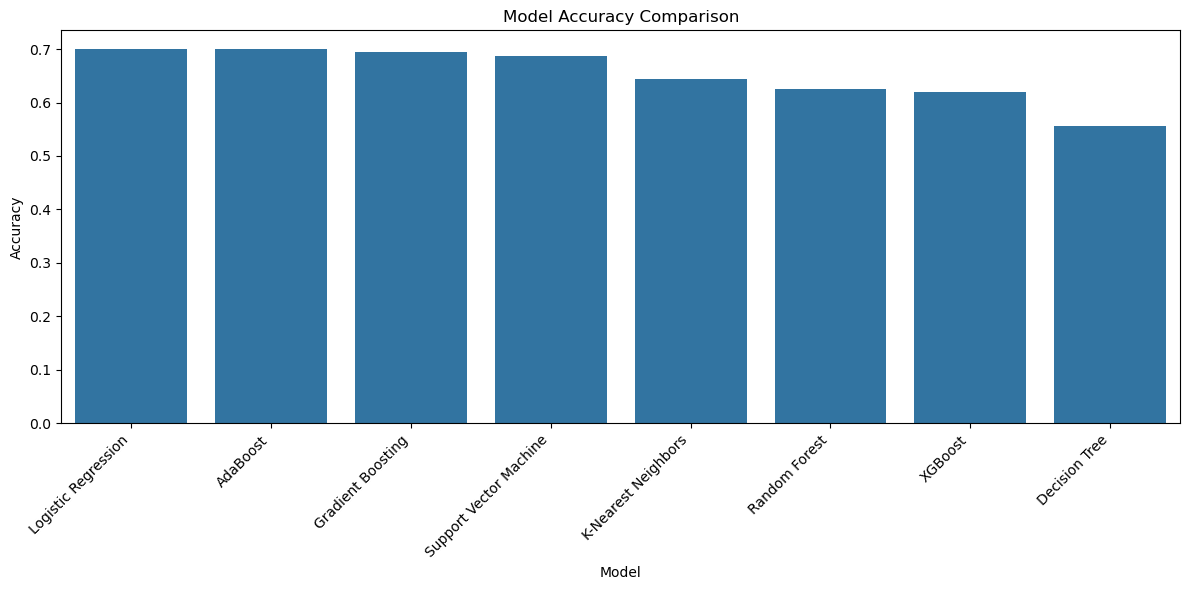

In [16]:
# Visualize accuracy results
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df.sort_values('Accuracy', ascending=False))
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:

# Find the best model (using F1 score which balances precision and recall)
best_idx = results_df['Accuracy'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_model = [r['model'] for r in results if r['model_name'] == best_model_name][0]

print(f"\nBest performing model: {best_model_name}")
print(f"Accuracy: {results_df.loc[best_idx, 'Accuracy']:.4f}")
print(f"F1 Score: {results_df.loc[best_idx, 'F1 Score']:.4f}")



Best performing model: Logistic Regression
Accuracy: 0.7000
F1 Score: 0.0400


In [18]:
from sklearn.inspection import permutation_importance

if hasattr(best_model, 'feature_importances_'):
    print("\nTop Features by Importance:")
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns
    
    # Add permutation importance calculation
    print("\nTop Features by Permutation Importance (More Reliable):")
    perm_result = permutation_importance(
        best_model, X_test, y_test, 
        n_repeats=10,
        random_state=42
    )
    
    # Sort features by importance
    perm_importances = perm_result.importances_mean
    perm_indices = np.argsort(perm_importances)[::-1]
    
# Visualize permutation importance
    plt.figure(figsize=(12, 8))
    plt.title('Permutation Feature Importance (More Accurate)')
    plt.barh(range(min(10, len(perm_indices))), 
             perm_importances[perm_indices][:10], 
             align='center')
    plt.yticks(range(min(10, len(perm_indices))), 
              [columns[i] for i in perm_indices][:10])
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    # Print top 10 features
    for i, idx in enumerate(indices[:10]):
        print(f"{i+1}. {columns[idx]}: {importances[idx]:.4f}")

# Save the best model to a pickle file
model_filename = f"accident_pred_{best_model_name.replace(' ', '_').lower()}.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
print(f"\nBest model saved as: {model_filename}")




Best model saved as: accident_pred_logistic_regression.pkl
